# DATA PROCESSING STEPS

This notebook contains the preprocessing steps for our MRI volumetric data as mentioned in the thesis. Unfortunately, I am unable to upload the raw data to LumiNUS as the folder size is too large (even after compressing). Therefore, I provided the processed data after all the below steps in the "znorm_cropped_imgs" folder.

If you would like to perform the entire preprocessing steps, please reach out to me at e0325348@u.nus.edu or yousheng.toh@gmail.com so that I can give you the "mri_data/unprocessed_data" folder.

**IMPORTANT: ALL steps below have been performed with the final processed data ready in the "znorm_cropped_imgs" folder provided in the submitted code. There is no need to perform these processing steps again as they take quite some time to complete.**

## Data Cleaning 
#### (CAN BE SKIPPED, these steps already performed for data in "mri_data/unprocessed_data/")

Before beginning the preprocessing steps below, please ensure that all of the MRI data are stored in a directory (for e.g. "./mri_data/"). Please make sure that each subject (e.g. 002_S_0295) has his/her scans stored under a folder with his/her subject ID as the folder name. Please also note that any files belonging to subjects with unusual anatomy or with a different scanning orientation **must be removed**. You may remove these files before or after you complete all the preprocessing steps, since the preprocessing occurs on a per-image basis and will not affect the other images. However, they **must be removed** before you crop out the region of interest.

The subject IDs of these subjects that are to be removed are as stated in this list:

In [ ]:
import os, shutil

to_remove = ['023_S_0604', '130_S_4730', '023_S_0331', '130_S_0956',
             '013_S_1186', '067_S_1185', '006_S_4449', '019_S_4252', 
             '013_S_4731', '098_S_0172', '023_S_1289', '020_S_1288',
             '023_S_0061', '012_S_1321', '002_S_1261', '002_S_1070', 
             '002_S_1280', '002_S_1155', '023_S_1247', '002_S_0954']

subj_data_path = 'znorm_stripped_imgs'  # Key in the folder name here to remove all these files
for subj in os.listdir(subj_data_path):
    if subj in to_remove:
        shutil.rmtree(os.path.join(subj_data_path, subj))

The NIFTI file that contains the raw scan of the entire brain should be labelled {subject_id}\_raw.nii, the NIFTI files that contains the segmentation masks of the left and right hippocampus should be labelled ADNI\_{subject_id}\_L.nii and ADNI\_{subject_id}\_R.nii respectively. 

    > mri_data
        >> unprocessed_data
            >>> 002_S_0295
                >>>> 002_S_0295_raw.nii
                >>>> ADNI_002_S_0295_13722_L.nii
                >>>> ADNI_002_S_0295_13722_R.nii
            >>> 002_S_0059
                >>>> ...




While examining the images, I realised that the hippocampus masks files were incorrectly labelled (L should be R, R should be L) for the following four subjects:

* 007_S_1304
* 016_S_4121
* 029_S_4279
* 136_S_0429

Please **ensure that they are corrected by renaming these files**. For example, 'ADNI_007_S_1304_L.nii' should be renamed to 'ADNI_007_S_1304_R.nii' and 'ADNI_007_S_1304_R.nii' should be renamed to 'ADNI_007_S_1304_L.nii'.

**NOTE: These above steps have been performed in the "mri_data/unprocessed_data" folder already.**

## MRI Preprocessing (requires raw data to be performed)

To start, we perform the following steps (in this exact ordering):

1. Field Inhomogeneity Correction (Bias Field Correction) using N4 Bias Field Correction
2. Brain extraction (skullstripping) using ROBEX
3. Intensity normalization using Z-score normalization

The code required for each of the above steps can become quite complicated. In order to avoid unnecessary display of numerous lines of code, I have packaged them away into various helper functions within the data_utils.preprocessing module. All the above steps can be executed by just the three lines of code below.

In [ ]:
from data_utils.preprocessing import *

path_to_data = 'mri_data/unprocessed_data'  # Change this according to your path

n4bfc(path_to_data)
brain_extraction(path_to_data)
zs_intensity_norm(path_to_data)

After the above steps have been completed, the processed brain images should be in a newly created folder called 'mri_data/znorm_stripped_imgs'. We will then port over the hippocampus segmentation masks from the old folder using the port_over_masks function.

In [ ]:
from data_utils.preprocessing import port_over_masks
port_over_masks(
    'unprocessed_data', # old folder
    'znorm_stripped_imgs' # new folder
               )

Each subject's folder should contain the preprocessed brain MRI and the two hippocampus segmentation masks. I strongly recommend you to pull all the folders under 'mri_data/znorm_stripped_imgs' into a new folder called 'precrop_final_data1' that is on the same 'level' as the mri_data folder. This will reduce the chances of pathing errors. If done correctly, your current working directory should look something like this:

    > mri_data
        >> ...
    > precrop_final_data1
        >> 002_S_0295
            >>> ADNI_002_S_0295_L.nii
            >>> ADNI_002_S_0295_R.nii
            >>> 002_S_0295_znorm.nii
        >> 002_S_0059
            >>> ...

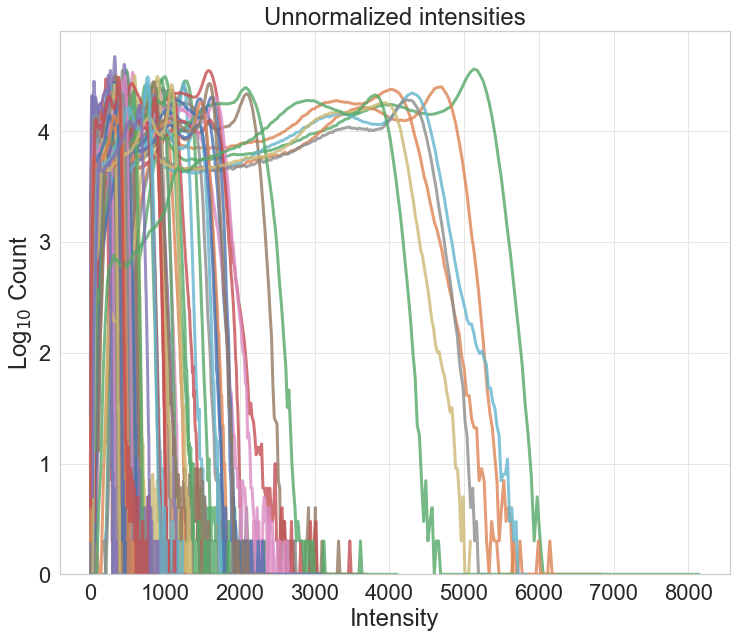

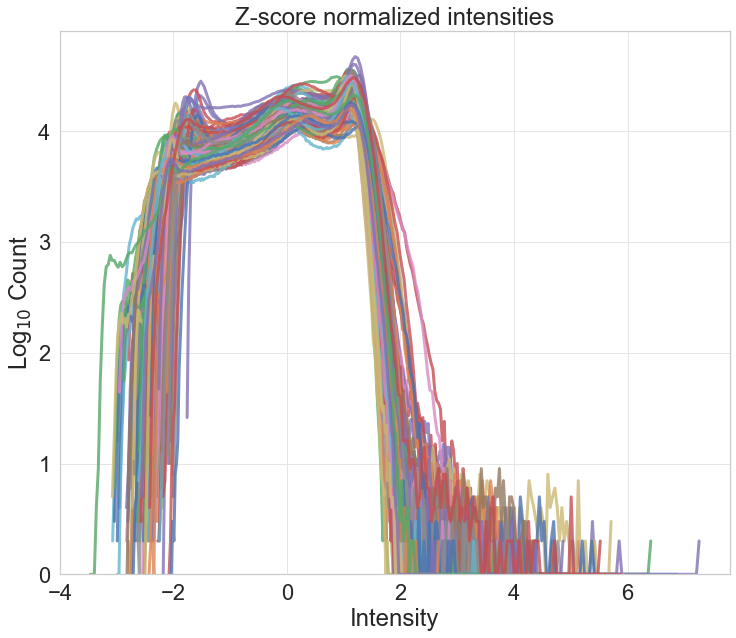

In [39]:
# For visualizing the intensity distribution (only re-run this cell if you performed the above preprocessing steps again)

from data_utils.preprocessing import plot_intensity_dist

plot_intensity_dist(imgs_path='mri_data/unprocessed_data', 
                    img_suffix='stripped.nii', 
                    mask_suffix='masked.nii', 
                    cropped=False,
                    title='Unnormalized intensities')

plot_intensity_dist(imgs_path='znorm_stripped_imgs', 
                    img_suffix='znorm.nii', 
                    mask_suffix='masked.nii', 
                    cropped=False,
                    title='Z-score normalized intensities')

## Extracting region of interest around the hippocampus

**Please make sure you have removed the 20 subjects that have incorrect orientation or unusual anatomy and corrected the mislabelled left and right hippocampus for the other 4 subjects stated above, before you proceed to the next steps\!** 

Next we crop the images to obtain the region surrounding the hippocampus. This is obtained by going over every image and detecting the maximal 'boundaries' of the hippocampus along the axial, sagittal and coronal views.

In [ ]:
from data_utils.preprocessing import find_max_boundary, get_bounding_boxes

left, right = find_max_boundary('znorm_stripped_imgs')

We then further expand the boundaries to obtain bounding boxes with dimensions that are evenly numbered, so as to avoid dimension shape incompatibility, since our U-Net based models performs downsampling followed by upsampling. Our region of interest is a bounding box/cuboid with dimensions of $40 \times 56 \times 72$.

In [ ]:
# Each input has dimensions 40x56x72
left = [[57, 96+1], [77, 132+1], [37, 108+1]]
right = [[100, 139+1], [81, 136+1], [38, 109+1]]
get_bounding_boxes(left, right, 'znorm_stripped_imgs', 'znorm.nii', 'znorm_cropped_imgs')

All the cropped and intensity normalized images are in your new folder(s) as specified in the `get_bounding_boxes` function. In this case, all the prepared MRI volumes are in 'znorm_cropped_imgs'. These volumes and their hippocampus masks are ready for training and the train-test split will be performed in the "Training.ipynb" notebook.